In [1]:
from IPython.core.pylabtools import figsize
%config InlineBackend.figure_formats = ['svg']
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from templatefitting import *
from ptbinnedfittinghelpers import *

In [3]:
lumi = 140 # fb

# Loading Data, Templates and ang coeffs

In [4]:
# Setup
cuts = 'cuts'

pathtoptbins = '/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_ptbinned/ptbins.txt'
pathtodata = '/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_ptbinned/histo_'+cuts
pathtocoeffs = '/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_ptbinned/histo_nocuts'
pathtotemplates = f'templates/ptbinned/Zjj_ptbin_temps_{cuts}0'

_load = 'full'
overflow = True
uncertgoal = .1

In [5]:
if overflow:
    data, data_of, temps, temps_of, ptbins, angbins, coeffs, coeffs_of = load(pathtodata, pathtotemplates, pathtoptbins, pathtocoeffs, _load, overflow)
else:
    data, temps, ptbins, angbins, coeffs = load(pathtodata, pathtotemplates, pathtoptbins, pathtocoeffs, _load, overflow)

full
loading full data from /home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_ptbinned/histo_cuts with 44 bins
loading full templates from templates/ptbinned/Zjj_ptbin_temps_cuts0 with 44 bins
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin0_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin1_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin2_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin3_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin4_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin5_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin6_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin7_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin8_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin9_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/ptbin10_2D0.json
LOADING:  templates/ptbinned/Zjj_ptbin_temps_cuts0/

# Some Testing

In [6]:
# def load_data(path_to_data, value_key="yvals"):
#     """
#     Loads data from JSON file
#     :param path_to_data:
#     :return: xe, dx, n
#     """
#     # load data
#     with open(path_to_data, 'r') as f:
#         data = json.load(f)
#     xe = np.array(data['bins'])
#     dx = xe[1] - xe[0]p.fitting()
#
#     n = np.array(data[value_key]) * dx * lumi
#     return xe, dx, n
#
# xe_cos, dx_cos, n_cos = load_data('templates/data_2d_nocuts/costheta.json')
# xe_phi, dx_phi, n_phi = load_data('templates/data_2d_nocuts/phi.json')
#
# # loading data and templates
# with open("templates/data_2d_nocuts/data_2d.json", "r") as f:
#     data = json.load(f)
# xe = np.array(data["bins"])
# dx = np.array((xe[0,1] - xe[0, 0], xe[1,1] - xe[1, 0]))
# da = np.prod(dx)
# n = np.array(data["zvals"]) * da * lumi
# # n = n.reshape(40,40)
# # cos(theta) along collums
# # phi along rows
#
# prefix = "templates/2d_nocuts/temps_2D"
# ts = []
# for i in range(9):
#     with open(prefix + str(i) + ".json", "r") as f:
#         ts.append(json.load(f)["zvals"])
# ts = np.array(ts)

print(pt[0]['cos'][0])

In [7]:
# _pt = load(pathtodata, pathtotemplates, pathtoptbins, _load, True)
# s = np.zeros(8)
# for i in range(37):
#     s += np.array(_pt[0]['cos'][i])
# print(s)
# print(np.sum(s*lumi*0.25))
# print(np.sum(n_cos))
# del _pt
# del s; del xe; del dx; del n_cos; del ts; del n; del xe_phi; del dx_phi; del xe_cos; del dx_cos

In [42]:
class ptbinnedfits:
    def __init__(self, data, xsec, templates, ang_bins, ptbins, coeffs=None, data_of=None, xsec_of=None, temps_of=None, coeffs_of=None, lumi=140, fitclass=TemplateFits_2d, uncertgoal=0.1):
        self.dx = (angbins[0][1] - angbins[0][0]) * (angbins[1][1] - angbins[1][0])
        self.data = np.array(data) * lumi * self.dx
        self.templates = np.array(templates)
        self.xsec = np.array(xsec)
        self.ptbins = np.array(ptbins)
        self.fitclass = fitclass
        self.ang_bins = np.array(ang_bins)
        self.lumi = lumi
        if data_of is not None:
            self.data_of = np.array(data_of) * lumi * self.dx
        else:
            self.data_of = None

        if temps_of is not None:
            self.temps_of = np.array(temps_of)
        else:
            self.temps_of = None

        if coeffs is None:
            self.coeffs = np.ones((len(ptbins) - 1, 9))
        else:
            self.coeffs = coeffs
            for i in range (len(ptbins) - 1):
                self.coeffs[i,8] = xsec[i][0]

        if coeffs_of is None:
            self.coeffs_of = np.ones(9)
        else:
            self.coeffs_of = coeffs_of
            self.coeffs_of[8] = xsec_of[0]

        self.uncertgoal = uncertgoal
        self.datashape = (int(np.sqrt(len(self.data[0,:]))), int(np.sqrt(len(self.data[0,:]))))

    def fitting(self, mergelist="auto"):
        self.fitparams = []
        self.fiterrors = []
        self.fitptbins = [self.ptbins[-1]]
        self.minuit = []
        if not mergelist:
            mergelist =  np.ones(len(self.ptbins - 1))
        elif mergelist == "auto":
            i = 0
            n = len(self.ptbins)
            rebin = False
            while i < n - 1:
                data = self.data[-1-i]
                temps = self.templates[-1-i]
                coeffs = self.coeffs[-1-i,:] / np.append(np.ones(8), 5)
                # print('dat: ', data)
                # print('temps: ', temps)
                # print(coeffs)
                m = self.fit_helper(data, temps, coeffs)
                # print('dat: ', data)
                # print('temps: ', temps)
                j = 0

                while m == -1 and i+j+1 < n - 1:
                    j += 1
                    print("first loop j: ", j)
                    data = np.sum(self.data[n-i-j-2:n-i-1,:], axis=0)
                    temps = np.sum(self.templates[n-i-j-2:n-i-1,:], axis=0)
                    # print("SUMTS: ", np.sum(temps.T, axis=1))
                    # print("DATA: ", data)
                    print("ptbin verifying")
                    # print(ptbins[n-1-i] - ptbins[n-i-j-2])
                    print(np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2])))
                    coeffs = np.sum(self.coeffs[n-i-j-2:n-i-1,:], axis=0) / np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2]))
                    print(coeffs)
                    # print(data.shape, temps.shape)
                    m = self.fit_helper(data, temps, coeffs)
                if m == -1:
                    print("------------------------------------------------------------------")
                    print("rebinning cos")
                    print("------------------------------------------------------------------")
                    rebin = True
                    j = 0
                    while m == -1 and i+j < n - 1:
                        
                        print("rebin j: ", j)
                        data = np.sum(self.data[n-i-j-2:n-i-1,:], axis=0)
                        temps = np.sum(self.templates[n-i-j-2:n-i-1,:], axis=0)
                        data, temps = self.rebin(data, temps)
                        # print("SUMTS1: ", np.sum(temps.T, axis=1))
                        # print("DATA1: ", data)
                        print("ptbin verifying")
                        # print(ptbins[n-1-i] - ptbins[n-i-j-2])
                        print(np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2])))
                        coeffs = np.sum(self.coeffs[n-i-j-2:n-i-1,:], axis=0) / np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2]))
                        print(coeffs)
                        # print(data.shape, temps.shape)
                        m = self.fit_helper(data, temps, coeffs)
                        j += 1
                if m == -1:
                    print("i: ", i,", j: ", j,  "n-1: ", n-1, i+j+1)
                    raise Exception("skdlflksjflksdf")

                # print(i+j+1 < n - 1)
                # print(i, j, n)
                # print(m)
                while (m.merrors['x0'].upper / m.values['x0'] > self.uncertgoal or m.merrors['x0'].lower / m.values['x0'] > self.uncertgoal) and i+j+1 < len(self.ptbins) - 1:
                    print(f"Merrors > {self.uncertgoal * 100:.2f}%: {m.merrors['x0'].upper / m.values['x0']}, {m.merrors['x0'].lower / m.values['x0']} in bin [{self.ptbins[n-i-j-2]}, {self.ptbins[n-1-i]}]")
                    j += 1
                    print("final j: ", j)
                    data = np.sum(self.data[n-i-j-2:n-i-1,:], axis=0)
                    temps = np.sum(self.templates[n-i-j-2:n-i-1,:], axis=0)
                    if rebin:
                        data, temps = self.rebin(data, temps)
                    # print(np.sum(temps.T, axis=1))
                    print("ptbin verifying")
                    # print(ptbins[n-1-i] - ptbins[n-i-j-2])
                    print(np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2])))
                    coeffs = np.sum(self.coeffs[n-i-j-2:n-i-1,:], axis=0) / np.append(np.ones(8) * (j+1), (ptbins[n-1-i] - ptbins[n-i-j-2]))
                    print(coeffs)
                    # print(data.shape, temps.shape)
                    m = self.fit_helper(data, temps, coeffs)
                self.minuit.append(m)
                self.fitparams.insert(0, m.values)
                self.fiterrors.insert(0, m.merrors)
                self.fitptbins.insert(0, self.ptbins[n-i-j-2])
                print(f"reached precision in bin: [{ptbins[n-i-j-2]}, {self.ptbins[n-1-i]}")
                print(m)
                print("---------------------------------------------------------")
                i += j + 1
                print("i: ", i)
            #TODO overflow fitting
            if self.data_of is not None and self.temps_of is not None:
                print("fitting overflow")
                m = self.fit_helper(self.data_of, self.temps_of, self.coeffs_of * np.append(np.ones(8), 1 / (1000 - ptbins[-1])))
                self.fitparams_of = m.values
                self.fiterrors_of = m.merrors



        # if sum(mergelist) != len(self.ptbins) - 1:
        #     raise Exception("mergelist passt nicht")
        # rebin(mergelist)

    def rebin(self, data, temps):
        # if all(elem == 1 for elem in mergelist):
        #     self.fitdata = self.data
        #     self.fittemplates = self.templates
        #     self.fitdxsec = self.dxsec
        #     self.fitptbins = self.ptbins
        # else:
        #     i = 0
        #     data = []
        #     for elem in mergelist:
        #         temp = i+elem
        #         data.append(np.sum(self.data[i:temp+1])) #TODO check slicing logic
        #         i += temp

        newdata = self.rebin_cos_data(data)
        newtemps = []
        for i in range(9):
            t = newtemps.append(self.rebin_cos_data(temps[i,:]))
        return newdata, np.array(newtemps)


    def rebin_cos_data(self, data):
        d = data.reshape(self.datashape)
        temp = np.zeros((self.datashape[0]-2, self.datashape[1]))
        i = 0
        temp[i,:] = np.sum(d[i:i+2,:], axis=0)
        for i in range(1, self.datashape[0]-3):
            temp[i,:] = d[i+1,:]
        i = self.datashape[0]-3
        temp[i, :] = np.sum(d[i+1:,:], axis=0)
        # self.datashape = (temp.shape)
        return temp.flatten()


    def rebin_cos_template(self, templates):
        for i in range(9):
            templates = self.rebin_cos_data( templates[i,:] )

    def fit_helper(self, data, templates, coeffs):
        print("Temphape: ",templates.shape)
        print("datashape: ", data.shape)
        m = Minuit(self.fitclass(self.dx, templates.T, data, coeffs, self.lumi), coeffs)
        # m.fixed[3] = True
        m.migrad()
        try:
            m.minos()
        except RuntimeError:
            print(f"No valid minimum found")
            return -1
        return m

    def plotting(self, plotselect='full', kwargs=None, figsavekwargs=None, figsize=(15,15)):
        with plt.rc_context({
        'font.size': 12,  # Base font size
        'axes.labelsize': 12,  # Axis label font size
        'axes.titlesize': 14,  # Title font size
        'xtick.labelsize': 10,  # X-tick label font size
        'ytick.labelsize': 10,  # Y-tick label font size
        'legend.fontsize': 10  # Legend font size
        }):
            if kwargs is None:
                kwargs = {"fmt": "o", "ms": 5, "capsize": 6}
            if figsavekwargs is None:
                figsavekwargs = dict(dpi=300, transparent=False)
            pt, ptxerr = self.plotpt()
            y = np.array(self.fitparams)
            ylo, yup = self.plotyerr()
            if plotselect == 'full':
                if self.fitparams_of is None:
                    fig, ax = plt.subplots(9, 1, figsize=figsize)
                    for i in range(9):
                        ax[i].set_xlim(20, 200)
                        ax[i].set_xlabel('$p_T$ / [GeV]')
                        ax[i].set_ylabel(f'$A_{i}$')
                        ax[i].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                else:
                    fig = plt.figure(figsize=figsize, constrained_layout=False)
                    ax = [[0 for l in range(2)] for k in range(9)]
                    gs = fig.add_gridspec(9, 6, wspace=0.05, hspace=0.3)
                    for i in range(9):
                        ax[i][0] = fig.add_subplot(gs[i,:-1])
                        ax[i][1] = fig.add_subplot(gs[i,-1])
                    # fig.text(0.5, 0.08, '$p_T$ / [GeV]', ha='center')
                    ax = np.array(ax)
                    for i in range(9):
                        print(i)
                        ax[i, 0].sharey(ax[i, 1])
                        ax[i, 0].set_xlim(min(self.ptbins) - 10, max(self.ptbins) + 10)
                        # print(ax.shape)
                        ax[i, 0].set_ylabel(f'$A_{i}$')
                        if i == 8:
                            ax[i, 0].set_yscale('log')
                            ax[i, 0].set_ylabel('d$\\sigma$ / d$p_{T,\ell\ell}$ [fb / GeV]')
                            ax[i, 0].set_xlabel('$p_T^{\mathrm{Z}}$ [GeV]')
                        x = np.linspace(20,200)
                        yp = x*0.1
                        # ax[i, 0].plot(x, yp)
                        # print("bins: ",pt)
                        # print("y: ", y[i])
                        # print(y[:i].shape)
                        # ax[i, 0].errorbar(x, yp, xerr=0.1*x, yerr=np.sqrt(yp), **kwargs)
                        ax[i, 0].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                        ax[i, 1].set_xlim(0, 1)
                        ax[i, 1].set_xticks([0.5])
                        ax[i, 1].set_xticklabels(["overflow"])
                        try:
                            ax[i, 1].errorbar(0.5 , self.fitparams_of[i], yerr=[[abs(self.fiterrors_of[f"x{i}"].lower)], [self.fiterrors_of[f"x{i}"].upper]], **kwargs)
                        except KeyError:
                            ax[i, 1].errorbar(0.5 , self.fitparams_of[i], yerr=0.00001, **kwargs)
                        # hide the spines between ax and ax2
                        ax[i, 0].spines['right'].set_visible(False)
                        ax[i, 1].spines['left'].set_visible(False)
                        ax[i, 0].yaxis.tick_left()
                        # ax[i, 0].tick_params(labelright='off')
                        ax[i, 1].tick_params(labelleft='off')
                        ax[i, 1].yaxis.tick_right()

                        # This looks pretty good, and was fairly painless, but you can get that
                        # cut-out diagonal lines look with just a bit more work. The important
                        # thing to know here is that in axes coordinates, which are always
                        # between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
                        # (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
                        # appropriate corners of each of our axes, and so long as we use the
                        # right transform and disable clipping.

                        d = .01  # how big to make the diagonal lines in axes coordinates
                        # arguments to pass plot, just so we don't keep repeating them
                        anzdia=int(9)
                        kwargs1 = dict(transform=ax[i, 0].transAxes, color='k', clip_on=False)
                        ax[i, 0].plot((1-d, 1+d), (-d*anzdia, +d*anzdia), **kwargs1)
                        ax[i, 0].plot((1-d, 1+d), (1-d*anzdia, 1+d*anzdia), **kwargs1)

                        kwargs1.update(transform=ax[i, 1].transAxes)  # switch to the bottom axes
                        ax[i, 1].plot((-d*5, +d*5), (1-d*anzdia, 1+d*anzdia), **kwargs1)
                        ax[i, 1].plot((-d*5, +d*5), (-d*anzdia, +d*anzdia), **kwargs1)

                    fig.savefig(f'ptbinned-fits-full_{cuts}.png', **figsavekwargs)
                    print(f"saved as: ptbinned-fits-full_{cuts}.png")

            elif is_iterable(plotselect):
                if self.fitparams_of is None:
                    fig, ax = plt.subplots(len(plotselect), 1, figsize=figsize)
                    for j, i in enumerate(plotselect):
                        i =  int(i)
                        ax[j].set_xlim(20, 200)
                        ax[j].set_xlabel('$p_T$ / [GeV]')
                        ax[j].set_ylabel(f'$A_{i}$')
                        ax[j].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                else:
                    fig = plt.figure(figsize=figsize, constrained_layout=False)
                    ax = [[0 for l in range(2)] for k in range(len(plotselect))]
                    gs = fig.add_gridspec(len(plotselect), 6, wspace=0.05, hspace=0.2)
                    for i in range(len(plotselect)):
                        ax[i][0] = fig.add_subplot(gs[i,:-1])
                        ax[i][1] = fig.add_subplot(gs[i,-1])
                    # fig.text(0.5, 0.08, '$p_T$ / [GeV]', ha='center')
                    ax = np.array(ax)
                    for j, i in enumerate(plotselect):
                        print(j)
                        ax[j, 0].sharey(ax[j, 1])
                        ax[j, 0].set_xlim(min(self.ptbins)-10, max(self.ptbins) + 10)
                        # print(ax.shape)
                        ax[j, 0].set_ylabel(f'$A_{i}$')
                        if i == 8:
                            ax[j, 0].set_yscale('log')
                            ax[j, 0].set_ylabel('d$\\sigma$ / d$p_{T,\ell\ell}$ [fb / GeV]')
                        # x = np.linspace(20,200)
                        # yp = x*0.1
                        # ax[j, 0].plot(x, yp)
                        # print("bins: ",pt)
                        # print("y: ", y[i])
                        # print(y[:i].shape)
                        # ax[j, 0].errorbar(x, yp, xerr=0.1*x, yerr=np.sqrt(yp), **kwargs)
                        ax[j, 0].errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                        ax[j, 1].set_xlim(0, 1)
                        ax[j, 1].set_xticks([0.5])
                        ax[j, 1].set_xticklabels(["overflow"])
                        ax[j, 1].errorbar(0.5 , self.fitparams_of[i], yerr=[[abs(self.fiterrors_of[i].lower)], [self.fiterrors_of[i].upper]], **kwargs)

                        # hide the spines between ax and ax2
                        ax[j, 0].spines['right'].set_visible(False)
                        ax[j, 1].spines['left'].set_visible(False)
                        ax[j, 0].yaxis.tick_left()
                        # ax[j, 0].tick_params(labelright='off')
                        ax[j, 1].tick_params(labelleft='off')
                        ax[j, 1].yaxis.tick_right()

                        # This looks pretty good, and was fairly painless, but you can get that
                        # cut-out diagonal lines look with just a bit more work. The important
                        # thing to know here is that in axes coordinates, which are always
                        # between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
                        # (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
                        # appropriate corners of each of our axes, and so long as we use the
                        # right transform and disable clipping.

                        d = .01  # how big to make the diagonal lines in axes coordinates
                        # arguments to pass plot, just so we don't keep repeating them
                        anzdia=int(len(plotselect))
                        kwargs1 = dict(transform=ax[j, 0].transAxes, color='k', clip_on=False)
                        ax[j, 0].plot((1-d, 1+d), (-d*anzdia, +d*anzdia), **kwargs1)
                        ax[j, 0].plot((1-d, 1+d), (1-d*anzdia, 1+d*anzdia), **kwargs1)

                        kwargs1.update(transform=ax[j, 1].transAxes)  # switch to the bottom axes
                        ax[j, 1].plot((-d*5, +d*5), (1-d*anzdia, 1+d*anzdia), **kwargs1)
                        ax[j, 1].plot((-d*5, +d*5), (-d*anzdia, +d*anzdia), **kwargs1)
                        savename = ''
                        for i in plotselect:
                            savename += f'A_{i}+'
                    fig.savefig(f'ptbinned-fits-{savename[:-1]}_{cuts}.png', **figsavekwargs)
                    print(f"saved as: ptbinned-fits-{savename[:-1]}_{cuts}.png")


            elif isinstance(plotselect, int):
                if self.fitparams_of is None:
                    fig, ax = plt.subplots(figsize=figsize)
                    i = plotselect
                    ax[0].set_xlim(min(self.ptbins), max(self.ptbins))
                    ax.set_xlabel('$p_T$ / [GeV]')
                    ax.set_ylabel(f'$A_{i}$')
                    ax.errorbar(pt, y[:,i], xerr=ptxerr, yerr=[ylo[i], yup[i]], **kwargs)
                else:
                    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [5,1], 'wspace': 0.02}, figsize=figsize, sharey=True)
                    i = plotselect
                    ax[0].set_xlim(min(self.ptbins)-10, max(self.ptbins) + 10)
                    # fig.text(0.5, 0.08, '$p_T$ / [GeV]', ha='center')
                    ax[0].set_xlabel('$p_T$ / [GeV]')
                    ax[0].set_ylabel(f'$A_{i}$')
                    if i == 8:
                        ax[0].set_yscale('log')
                        ax[0].set_ylabel('d$\\sigma$ / d$p_{T,\ell\ell}$ [fb / GeV]')
                    ax[0].errorbar(pt, y[:,i]/2, xerr=ptxerr, yerr=[ylo[i]/2, yup[i]/2], **kwargs)
                    ax[1].set_xlim(0, 1)
                    ax[1].set_xticks([0.5])
                    ax[1].set_xticklabels(["overflow"])
                    ax[1].errorbar(0.5 , self.fitparams_of[i]/2, yerr=[[abs(self.fiterrors_of[i].lower) /2 ], [self.fiterrors_of[i].upper / 2]], **kwargs)

                    # hide the spines between ax and ax2
                    ax[0].spines['right'].set_visible(False)
                    ax[1].spines['left'].set_visible(False)
                    ax[0].yaxis.tick_left()
                    # ax[0].tick_params(labelright='off')
                    ax[1].tick_params(labelleft='off')
                    ax[1].yaxis.tick_right()

                    # This looks pretty good, and was fairly painless, but you can get that
                    # cut-out diagonal lines look with just a bit more work. The important
                    # thing to know here is that in axes coordinates, which are always
                    # between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
                    # (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
                    # appropriate corners of each of our axes, and so long as we use the
                    # right transform and disable clipping.

                    d = .01  # how big to make the diagonal lines in axes coordinates
                    # arguments to pass plot, just so we don't keep repeating them
                    kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)

                    ax[0].plot((1-d, 1+d), (-d, +d), **kwargs)
                    ax[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

                    kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
                    ax[1].plot((-d*5, +d*5), (1-d, 1+d), **kwargs)
                    ax[1].plot((-d*5, +d*5), (-d, +d), **kwargs)

                    fig.savefig(f'ptbinned-fits-A_{plotselect}_{cuts}.png', **figsavekwargs)
                    print(f"saved as: ptbinned-fits-A_{plotselect}_{cuts}.png")

            else:
                raise NotImplementedError("Not yet implemented.")


        plt.show()
        return fig, ax


    def plotpt(self):
        pt = []
        ptxerr = []

        for i in range(len(self.fitptbins)-1):
            pt.append((self.fitptbins[i] + self.fitptbins[i+1]) / 2)
            ptxerr.append((self.fitptbins[i+1] - self.fitptbins[i]) / 2)
        return np.array(pt), np.array(ptxerr)

    def plotyerr(self):
        ylo = []
        yup = []
        for i in range(9):
            ylo.append([])
            yup.append([])
            for j in range(len(self.fiterrors)):
                try:
                    ylo[i].append(abs(self.fiterrors[j][f"x{i}"].lower))
                    yup[i].append(self.fiterrors[j][f"x{i}"].upper)
                except KeyError:
                    ylo[i].append(0.00001)
                    yup[i].append(0.00001)
        return np.array(ylo), np.array(yup)




In [43]:
if overflow:
    p = ptbinnedfits(data['2D'], data['xsec'],temps['2D'], angbins, ptbins, coeffs, data_of['2D'], data_of["xsec"], temps_of['2D'], coeffs_of, uncertgoal=uncertgoal)
else:
    p = ptbinnedfits(data['2D'], data['xsec'], temps['2D'], angbins, ptbins, coeffs, uncertgoal=uncertgoal)

In [44]:
p.fitting()

Temphape:  (9, 64)
datashape:  (64,)
No valid minimum found
first loop j:  1
ptbin verifying
[ 2.  2.  2.  2.  2.  2.  2.  2. 50.]
[1.00928709 0.18819783 0.72468826 0.0867861  0.06295161 0.05202647
 0.01546891 0.01199464 0.01664702]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 0.26179543553794743, -0.28241468521658825 in bin [350.0, 400.0]
final j:  2
ptbin verifying
[ 3.  3.  3.  3.  3.  3.  3.  3. 75.]
[ 0.93103226  0.16225901  0.72479207 -0.01883847  0.03311232  0.09617515
 -0.01987904 -0.02987236  0.01897776]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 0.23671001882685594, -0.2524487074075631 in bin [325.0, 400.0]
final j:  3
ptbin verifying
[  4.   4.   4.   4.   4.   4.   4.   4. 100.]
[ 0.88431507  0.10806139  0.79575445 -0.01672032  0.01759622  0.06700803
 -0.05713324  0.00163392  0.02116336]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 0.21209557394286868, -0.22317579320361824 in bin [300.0, 400.0]
final j:  4
ptbin verifying
[  5.   5.   5.   5.

/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/templatefitting.py:88: RuntimeWarning: divide by zero encountered in log
  l = -1 * np.sum((np.log(lam).T * self.data).T - lam)
/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/templatefitting.py:88: RuntimeWarning: invalid value encountered in multiply
  l = -1 * np.sum((np.log(lam).T * self.data).T - lam)


Merrors > 10.00%: 0.12671431743945805, -0.13140449457134562 in bin [225.0, 400.0]
final j:  7
ptbin verifying
[  8.   8.   8.   8.   8.   8.   8.   8. 200.]
[ 0.92612356  0.03778876  0.84834087  0.00206688 -0.0183353   0.0298551
 -0.04194048  0.01727988  0.03601877]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 0.10546016694458343, -0.10894833300420054 in bin [200.0, 400.0]
final j:  8
ptbin verifying
[  9.   9.   9.   9.   9.   9.   9.   9. 205.]
[ 0.93799334  0.04515471  0.91458417  0.01841819 -0.02783004  0.04586613
 -0.03967517  0.01717783  0.0368821 ]
Temphape:  (9, 64)
datashape:  (64,)
Merrors > 10.00%: 0.10017097975703092, -0.10343760683048078 in bin [195.0, 400.0]
final j:  9
ptbin verifying
[ 10.  10.  10.  10.  10.  10.  10.  10. 210.]
[ 0.940313    0.03967867  0.89892448  0.01876957 -0.01079505  0.03770186
 -0.02105831  0.01688522  0.03816645]
Temphape:  (9, 64)
datashape:  (64,)
reached precision in bin: [190.0, 400.0
┌─────────────────────────────────────────────

In [45]:
for i in p.fitptbins:
    print(f"{i},\\ ", end="")

20.0,\ 60.0,\ 85.0,\ 100.0,\ 120.0,\ 145.0,\ 190.0,\ 400.0,\ 

In [46]:
# for m in range(len(p.templates.flatten())):
#     i,j,k = np.unravel_index(m, p.templates.shape)
#     if p.templates[i,j,k] == 0 and k == 63:
#         print(i, j, k)


saved as: ptbinned-fits-A_0_cuts.png


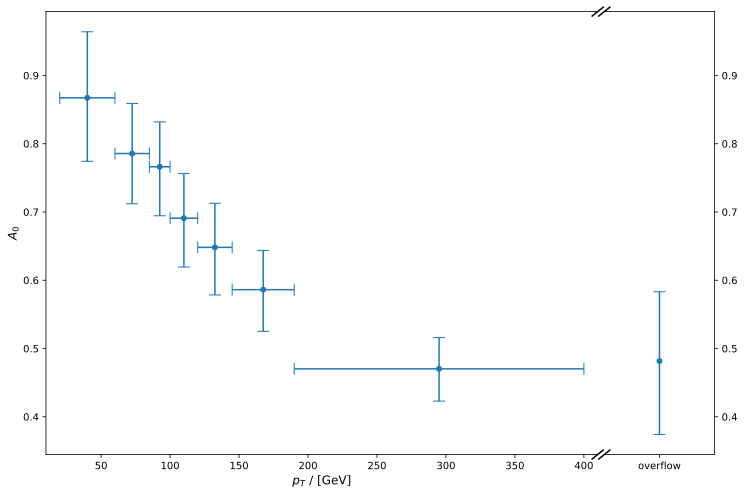

In [47]:
fig, ax = p.plotting( figsize=(18,24))

In [48]:
ax[0].set_ylabel('$f_L^Z$')
# fig.set_size_inches(16, 8)
plt.draw()
figsavekwargs = dict(dpi=300, transparent=True)
fig.savefig(f'ptbinned_fit_lpol_{cuts}.png', **figsavekwargs)

<Figure size 640x480 with 0 Axes>

In [22]:
bins = np.array([20,30,45,70,100,140,200,275,400,550,1050])
xsec_p = np.array( [ 210,190,180,130,150,110,59,31,8.8,1.4 ] ) / 1000
delta = np.array( [ 21,20,18,17,12,12,15,13,20,25  ] )
y_min = xsec_p - xsec_p * delta / 100
y_max = xsec_p + xsec_p * delta / 100
x = []
dx = []
dy = xsec_p * delta / 100
print(dy)
for i in range(len(bins) - 1):
    x.append((bins[i+1] + bins[i]) / 2)
    dx.append((bins[i+1] - bins[i]) / 2)
ax[8,0].errorbar(x, xsec_p, xerr=dx, yerr=dy, fmt='.k', label='PAPER')
ax[8,0].stairs(y_max, bins, baseline=y_min, color='b', fill=True, label='stat. uncert', alpha=0.5)
plt.draw()
fig.savefig("temp.png")

[0.0441  0.038   0.0324  0.0221  0.018   0.0132  0.00885 0.00403 0.00176
 0.00035]


<Figure size 640x480 with 0 Axes>

In [67]:
for i in range(len(p.fitptbins)):
    print(f"{p.fitptbins[i]:.0f}", end=', ')

20, 45, 70, 100, 160, 400, 

In [95]:
print(np.sum(p.templates[0, :], axis=0))
print(p.data[0,:])

[0.         0.01267304 0.00633651 0.         0.         0.01267303
 0.01267303 0.         0.05069211 0.05702866 0.04435561 0.08237461
 0.06336517 0.05702863 0.07004708 0.03801909 0.12039377 0.13306686
 0.12673029 0.10138413 0.14573985 0.13940333 0.08871119 0.1395985
 0.16474935 0.13940339 0.13306682 0.14573964 0.08871122 0.08486417
 0.15207638 0.17742245 0.1837589  0.10138426 0.16474944 0.11168746
 0.17108591 0.0950477  0.18375896 0.14573985 0.08237469 0.10772077
 0.11405727 0.1710857  0.07603818 0.10138425 0.13306682 0.10138427
 0.0443556  0.11405731 0.06336514 0.10138411 0.10138425 0.05702861
 0.03801909 0.03168258 0.         0.         0.01267303 0.
 0.         0.         0.00633651 0.        ]
[0.         0.3483682  0.17418412 0.         0.         0.34836811
 0.34836811 0.         1.39347222 1.5676564  1.21928845 2.26438989
 1.74184124 1.567656   1.92551989 1.04510447 3.3094964  3.65786586
 3.48368109 2.78694216 4.00623402 3.83205018 2.43857662 3.83741358
 4.5287844  3.83205115 3.

In [ ]:
cos = np.linspace(-1, 1, 8)
phi = np.linspace(0, 2*np.pi, 8)
n = len(p.data[:,0])
fig,ax = plt.subplots(n, figsize=(5,5*n))
for i in range(n):
    d = p.data[i, :].reshape((8,8))
    mesh = ax[i].pcolormesh(cos, phi, d)
    ax[i].set_title(f"datbin{i}")
    fig.colorbar(mesh, ax=ax[i])
plt.show()


In [ ]:
def diffcross_costheta(norm, cos_theta, A):
    p0 = A[0]/2 * (1 - 3 * cos_theta**2)
    p4 = A[4] * cos_theta
    p8 = 1 + cos_theta**2
    p = norm * np.array([p0, p4, p8])
    return 3 * np.sum(p, axis=0) / 8
fig, ax = plt.subplots(figsize=(8,8))
x = np.linspace(-1, 1, 9)
y = diffcross_costheta(p.fitparams_of[-1], x, p.fitparams_of)
coefflo = []
coeffup = []
for i in range(len(p.fitparams_of)):
    coefflo.append(p.fitparams_of[i] + p.fiterrors_of[i].lower)
    coeffup.append(p.fitparams_of[i] + p.fiterrors_of[i].upper)
ymin = np.sum(np.array(coefflo) * np.array(p.temps_of).T, axis=0)
ymax = np.sum(np.array(coeffup) * np.array(p.temps_of).T, axis=0)

# ax.stairs( ymax[:-1], x, baseline=ymin[:-1], fill=True)
ax.stairs( data_of["cos"], x)

In [ ]:
data_of["cos"]

In [ ]:
p.coeffs[:, 8]

In [ ]:
np.sum(data_of["cos"]) * 0.25 * lumi

In [ ]:
np.array(temps["2D"]).shape

In [ ]:
p.fiterrors_of[8].lower/p.fitparams_of[8]

In [ ]:
len(p.templates[0,0, :])

In [ ]:
p.templates.shape

In [ ]:
np.sum(t) * p.dx

In [ ]:
np.array(temps_of["2D"]).shape

In [ ]:
print(temps_of["2D"])

In [ ]:
a = np.zeros((9,9))
b = []
for i in range(9):
    for j in range(9):
        a[i][j] = i+j
for i in range(8):
    b.append(i)
a = np.array(a); b = np.array(b)

In [ ]:
i=2; j=3
n = len(a)
print(a[n-i-j-2], a[n-1-i])
print(b[n-i-j-2:n-i-1])
print(np.sum(a[n-i-j-2:n-i-1], axis=0) / np.append(np.ones(8) * (j + 1), 1))

In [ ]:
b[0:2]

In [ ]:
print(" ", b)

In [24]:
p.data[2].reshape(8,8)

array([[0.        , 1.21928876, 0.17418412, 0.        , 0.        ,
        0.52255223, 0.69673636, 0.        ],
       [1.0451042 , 2.63368134, 3.83205018, 0.87091923, 1.04510447,
        3.1353134 , 2.09020893, 0.87092034],
       [2.9611288 , 3.1353142 , 4.00623402, 3.30949303, 5.05133849,
        3.1353134 , 3.65786493, 3.48368109],
       [6.7931766 , 4.00623504, 4.18041786, 3.48367665, 4.18041786,
        4.00623402, 5.57389002, 4.87715464],
       [4.3546006 , 4.35460282, 4.7029694 , 4.52877979, 4.52878555,
        4.18041786, 5.39970618, 5.39970618],
       [3.3094964 , 3.30949809, 4.52878555, 3.65786027, 3.65786493,
        2.85275973, 4.18041786, 3.65786493],
       [0.69673618, 2.61276113, 2.26439278, 0.69673547, 0.69673636,
        2.26439278, 2.26439278, 0.52255223],
       [0.        , 0.17418417, 0.34836811, 0.        , 0.        ,
        0.        , 0.34836811, 0.        ]])